# Rolling GeoMAD

* **Products used:** 
[gm_s2_rolling](https://explorer.digitalearth.africa/gm_s2_rolling),
[ndvi_anomaly](https://explorer.digitalearth.africa/s2_l2a)

## Background

Satellite imagery allows us to observe the Earth with significant accuracy and detail. However, missing data &mdash; such as gaps caused by cloud cover &mdash; can make it difficult to put together a complete image. In order to produce a single, complete view of a certain area, satellite data may be consolidated, stacking measurements from different points in time to create a composite image.

The Digital Earth Africa (DE Africa) sentinel-2 Rolling GeoMAD (**Geo**median and **M**edian **A**bsolute **D**eviations) is the Geomedian and MADs calculated over moving window of 3 months. This is a cloud-free time series that can be used to monitor change on a more frequent basis than an annual or semiannual product.

Each product combines measurements collected over a 3-month period to produce one representative, multi-spectral image for every pixel of the African continent. The end result is a comprehensive dataset that can be used either to generate true-colour images for visual inspection of the landsacpe, or the full spectral dataset can be used to develop more complex algorithms.

**Important details:**

* Datacube product names: `gm_s2_rolling`
* Geomedian surface reflectance product
    * Valid scaling range: `1 - 10,000`
    * `0` is `no data`
* Median Absolute Deviation product
    * Valid scaling range: Spectral MAD: `0 - 1` , Bray-Curtis MAD `0 - 1`, Euclidean MAD `0 - 10,000` 
    * `NaN` is `nodata`
* Status: provisional
* Date-range: October 2020 &ndash; present
* Spatial resolution: 10m

For more information on DE Africa's GeoMAD service, see the DE Africa [GeoMAD](https://docs.digitalearthafrica.org/en/latest/data_specs/GeoMAD_specs.html).

## Description

In this notebook we will work with Sentinel-2 Rolling GeoMAD and NDVI Anomaly.
>Note: The GeoMAD product is suitable for calculating any indices, not just NDVI.

Topics covered include:
1. Inspecting the Rolling GeoMAD products and measurements available in the datacube
2. Load Rolling GeoMAD data
3. Display rgb of Rolling GeoMAD
4. Calculate NDVI from Rolling GeoMAD
5. Load NDVI monthly mean data
6. Plot the NDVI from Rolling GeoMAD and NDVI monthly mean
7. Compare zonal average NDVI from Rolling GeoMAD and NDVI monthly mean curve
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

import datacube
from datacube.utils.geometry import Geometry

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.bandindices import calculate_indices

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='rolling_geomad')

### List measurements

Inspect the measurement or bands available for the Sentinel-2 Rolling GeoMAD using datacube's `list_measurements` functionality.

In [3]:
product_name = 'gm_s2_rolling'

dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name].drop('flags_definition', axis=1)

name    dtype units  nodata                       aliases
measurement                                                            
B02            B02   uint16     1     0.0               [band_02, blue]
B03            B03   uint16     1     0.0              [band_03, green]
B04            B04   uint16     1     0.0                [band_04, red]
B05            B05   uint16     1     0.0         [band_05, red_edge_1]
B06            B06   uint16     1     0.0         [band_06, red_edge_2]
B07            B07   uint16     1     0.0         [band_07, red_edge_3]
B08            B08   uint16     1     0.0         [band_08, nir, nir_1]
B8A            B8A   uint16     1     0.0  [band_8a, nir_narrow, nir_2]
B11            B11   uint16     1     0.0    [band_11, swir_1, swir_16]
B12            B12   uint16     1     0.0    [band_12, swir_2, swir_22]
SMAD          SMAD  float32     1     NaN            [smad, sdev, SDEV]
EMAD          EMAD  float32     1     NaN            [emad, edev, EDEV]
BCMAD        BCMAD  float32     1     NaN         [bcmad, bcdev, BCDEV]
COUNT        COUNT   uint16     1     0.0                       [count]

### Define area of interest

In [4]:
#Specify the latitude, longitude, and buffer
aoi = define_area(lat=-1.77, lon=29.49, buffer=0.1)

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

### Display area of interest with a basemap using `display_map()`

In [5]:
display_map(x=lon_range, y=lat_range)

### Load Sentinel-2 Rolling GeoMAD data using `dc.load()`. 
For a more discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook

In [6]:
ds = dc.load(product="gm_s2_rolling",
             measurements=['red','green','blue','nir'],
             x=lon_range,
             y=lat_range,
             resolution=(-20, 20),
             output_crs = 'epsg:6933',
             time=("2021-01","2021-12"),
             
             )
display(ds)

<xarray.Dataset>
Dimensions:      (time: 14, y: 1276, x: 966)
Coordinates:
  * time         (time) datetime64[ns] 2020-12-16T23:59:59.999999 ... 2022-01...
  * y            (y) float64 -2.13e+05 -2.13e+05 ... -2.385e+05 -2.385e+05
  * x            (x) float64 2.836e+06 2.836e+06 ... 2.855e+06 2.855e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 376 357 430 436 413 ... 604 425 765 828
    green        (time, y, x) uint16 728 646 717 634 667 ... 693 457 849 906
    blue         (time, y, x) uint16 346 340 351 357 360 ... 937 480 301 576 628
    nir          (time, y, x) uint16 5048 3680 3404 3063 ... 3032 2860 3411 3061
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

### Display rgb of Sentinel-2 Rolling GeoMAD

We can plot the data we loaded using the `rgb()` function. By default, the function will plot data as a true colour image using the 'red', 'green', and 'blue' bands.

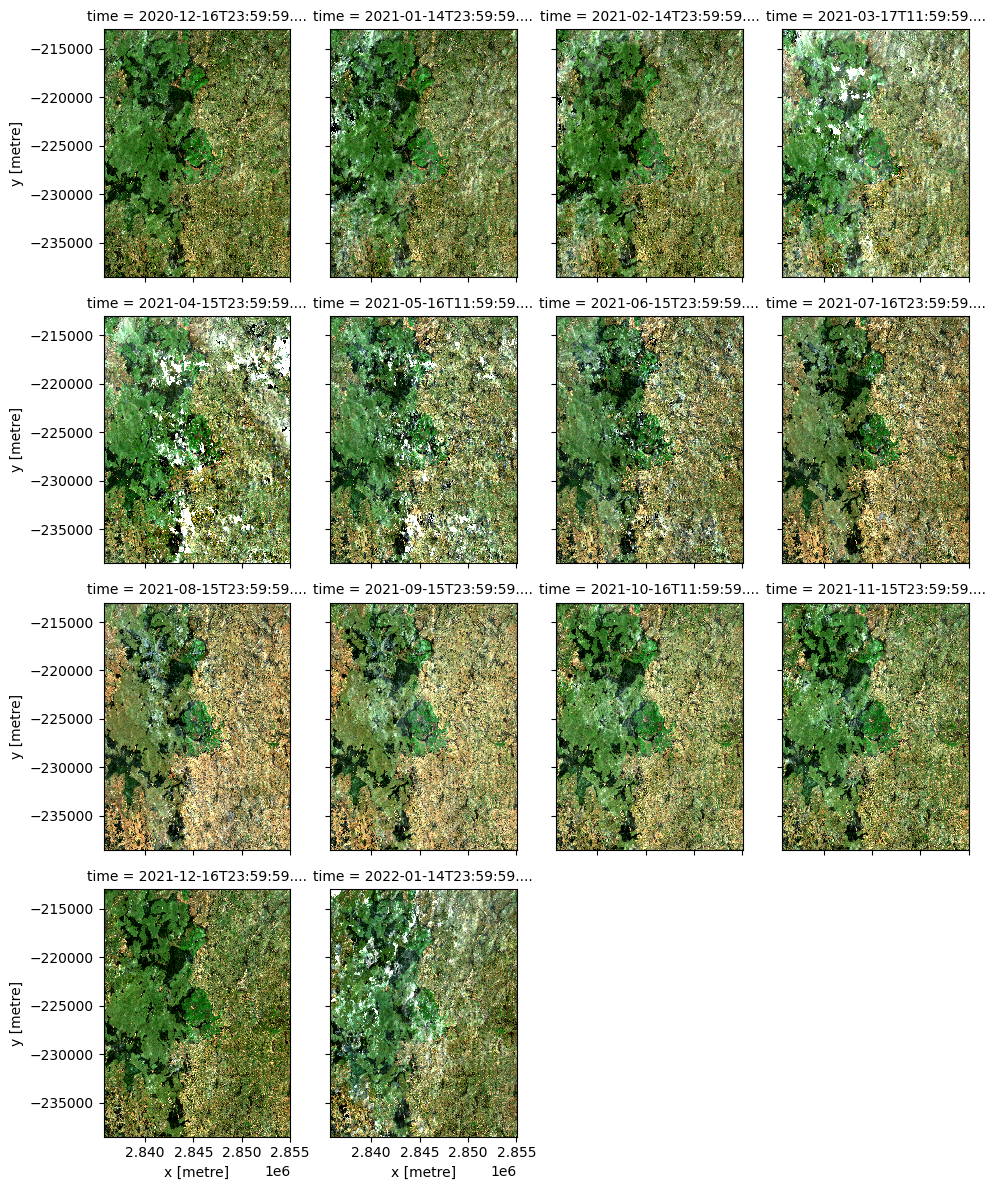

In [7]:
rgb(ds, col='time', col_wrap=4, size=3)

### Calculate NDVI using `calculate indices`
Refer to the [Calculating band indices](../Frequently_used_code/Calculating_band_indices.ipynb) notebook for more information. 
>Note: This product is suitable for calculating any indices, not just NDVI.

In [8]:
ds_NDVI = calculate_indices(ds, index=['NDVI'], satellite_mission='s2')

### Load monthly mean NDVI data using `dc.load()`.
Refer to the [NDVI Anomaly](../Datasets/NDVI_Anomaly.ipynb) notebook for more information NDVI mean.

In [9]:
monthly_ndvi = dc.load(
    product="ndvi_anomaly",
    time=("2021-01", "2021-12"),
    measurements = ['ndvi_mean'],
    like = ds.geobox,
)

#### Plot NDVI for selected months

NDVI for Rolling GeoMAD and Monthly Mean are plotted for January, April, July and November 2021, to visualise the area of interest. The output of these results will also be compared.

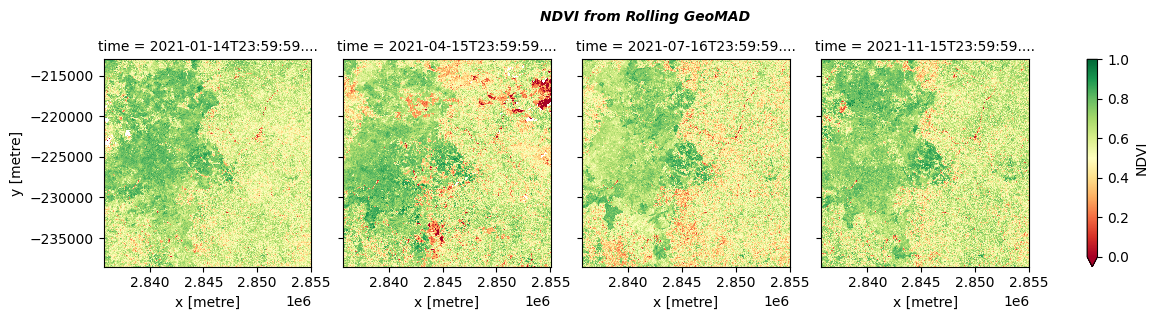

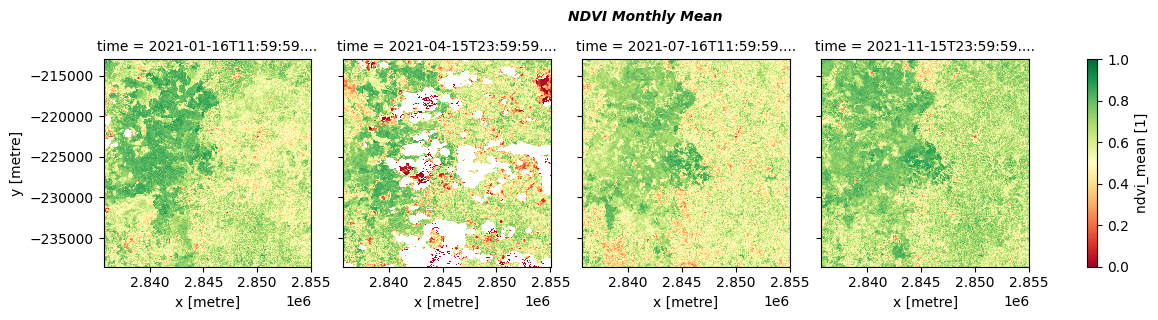

In [10]:
# NDVI Rolling GeoMAD
ds_NDVI.NDVI.isel(time=[1, 4, 7, 11]).plot(x='x',y='y', col='time', vmin=0, vmax=1, 
                                           cmap='RdYlGn', robust=True)
                                                  
# Title NDVI Rolling GeoMAD
plt.suptitle('NDVI from Rolling GeoMAD', y = 1.05, fontproperties={'style':'oblique', 'weight':'bold'})

# NDVI Monthly Mean
monthly_ndvi.ndvi_mean.isel(time=[0, 3, 6, 10]).plot(x='x',y='y', col='time', vmin=0, vmax=1, 
                                                     cmap="RdYlGn", robust=True)
# Title NDVI Rolling GeoMAD                                                  
plt.suptitle('NDVI Monthly Mean', y = 1.05, fontproperties={'style':'oblique', 'weight':'bold'})
                                                     
plt.show()

From the images above, the NDVI Rolling GeoMAD does not have any missing values in the images as compare to the NDVI monthly mean which has empty or missing values within for some pixels (comparing the month of April for both indicators). Secondly the image is smoother for the Rolling GeoMAD as compare to the Monthly mean. 

#### Compare zonal average NDVI from Rolling GeoMAD and the NDVI monthly mean curve

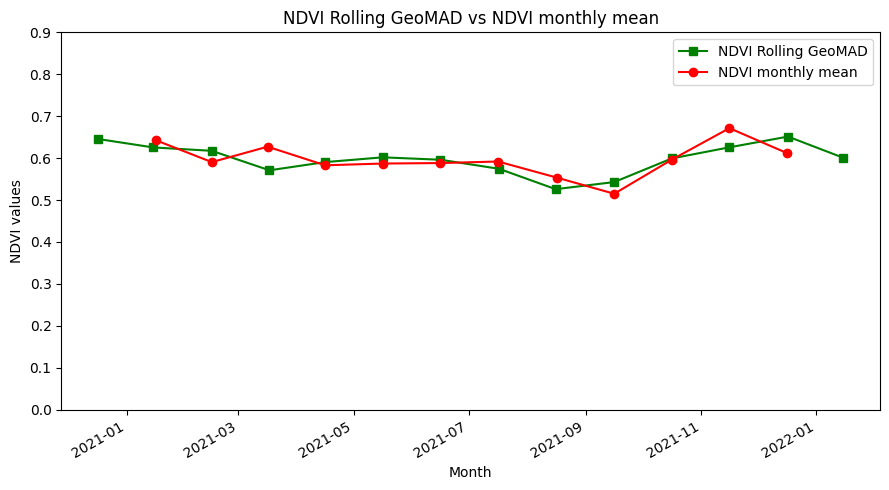

In [11]:
fig, ax = plt.subplots(figsize=(9, 5))

# Rolling GeoMAD 
ds_NDVI_mean = ds_NDVI.NDVI.mean(['x','y'])
ds_NDVI_mean.plot(marker='s', color='green', label='NDVI Rolling GeoMAD', ax=ax)

# Monthly Mean NDVI
ndvi_mean = monthly_ndvi.ndvi_mean.mean(['x','y'])
ndvi_mean.plot(marker='o', color='red', label='NDVI monthly mean', ax=ax)

plt.title('NDVI Rolling GeoMAD vs NDVI monthly mean')
plt.ylim(0, 0.9)
plt.xlabel('Month')
plt.ylabel('NDVI values')
plt.legend()
plt.tight_layout()

From the graph above, the NDVI Rolling GeoMAD is smoother due to the rolling window being equal to 3 months as compared to the NDVI monthly mean.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [12]:
print(datacube.__version__)

1.8.8


**Last Tested:**

In [13]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-05-31'